## Sources in which this notebook was inspired from 
### https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
### https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
### https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
### https://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb#topic=0&lambda=1&term=
### https://districtdatalabs.silvrback.com/principal-component-analysis-with-python
### https://plot.ly/ipython-notebooks/principal-component-analysis/
### https://www.kaggle.com/hamishdickson/training-and-plotting-word2vec-with-bigrams

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from mpl_toolkits.mplot3d import Axes3D
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import os
import time
import string
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import pickle
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
output_notebook()

Loading BokehJS ...

## Grabbing the full IMA data from SQL 

In [2]:
con = pyodbc.connect(r"Driver={/usr/local/lib/libmsodbcsql.17.dylib};Server=EPGLBSQLDSDV01,50429;Database=GILA;Trusted_Connection=yes;timeout=login_timeout")
rules = pd.read_sql(f'SELECT * FROM dbo.TrainingDB_v2 with(nolock) WHERE Comments IS NOT NULL', con)

## Creating a few cleaner functions for the Comments field 

In [3]:
def note_cleaner(rules_df):
    """
    This takes in the comments from the text cleans them for certain strings shown in note_list below
    :param rules_df: dataframe with current rules
    :return: dataframe with cleaned comments
    """
    note_list = ['OCU NOTE:', 'BBG NOTE: ', 'US NOTE:', 'AIM RULE:', 'MANUAL CHECK ON FAIL', 'NOTE:']
    rules_df['Comments'] = rules_df.Comments.str.split('|'.join(note_list)).str.get(0)
    return rules_df

In [4]:
def reference_sentence_preprocessing(clean_rules_df):
    '''
    Function that takes in a dataframe with SQL table with all fund mandate information.

    :param rules: pandas dataframe
    :return: list of word_tokenized paragraphs/sentences
    '''
    # NLTK word tokenizer with stop words removed
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stopped_sentences = []
    for row in clean_rules_df['Comments']:
        for sentence in nltk.sent_tokenize(row):
            cleaned_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
            cleaned_sentences = []
            for word in nltk.word_tokenize(cleaned_sentence):
                if word.lower() not in stop_words:
                    cleaned_sentences.append(word.lower())
            stopped_sentences.append(cleaned_sentences)
    return stopped_sentences

In [5]:
clean_rules_df = note_cleaner(rules)
stopped_sentences = reference_sentence_preprocessing(clean_rules_df)

In [6]:
import multiprocessing

cores = multiprocessing.cpu_count()

## Starting the training of the Word2Vec models on cleaned sentence data 

In [7]:
model_cbow = Word2Vec(size=100, #dimensionality of vectors
                      sample=0.001, # threshold for configuring which high-freq. words are randomly downsampled
                      alpha=0.025, # the initial learning rate 
                      min_count=2, # Ignores all words with total absolute frequency lower than this 
                      min_alpha=0.0001, #Learning rate will linearly drop to min_alpha as training progresses. 
                      sg=0, # 0= CBOW and 1= skipgram
                      workers=cores-1)

In [8]:
model_skipgram = Word2Vec(size=100, #dimensionality of vectors
                      sample=0.001, # threshold for configuring which high-freq. words are randomly downsampled
                      alpha=0.025, # the initial learning rate 
                      min_count=2, # Ignores all words with total absolute frequency lower than this 
                      min_alpha=0.0001, #Learning rate will linearly drop to min_alpha as training progresses. 
                      sg=1, # 0= CBOW and 1= skipgram
                      workers=cores-1)

## Build the Vocabulary 


In [9]:
model_cbow.build_vocab(stopped_sentences, progress_per=1000)

In [10]:
model_skipgram.build_vocab(stopped_sentences, progress_per=1000)

## Training the Model


In [11]:
model_cbow.train(stopped_sentences,
                total_examples=model_cbow.corpus_count, # count of sentences
                epochs=30, # number of iterations over the corpus
                report_delay=1)

(453747, 586590)

In [12]:
model_skipgram.train(stopped_sentences,
                total_examples=model_skipgram.corpus_count, # count of sentences
                epochs=30, # number of iterations over the corpus
                report_delay=1)

(453747, 586590)

In [13]:
model_cbow.init_sims(replace=True)
model_skipgram.init_sims(replace=True)

## Storing the word vectors in variables for PCA 

In [14]:
X_cbow = model_cbow[model_cbow.wv.vocab]
X_skip = model_skipgram[model_skipgram.wv.vocab]
len(X_cbow)
len(X_skip)

/Users/mm05392/anaconda3/envs/GILA/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Users/mm05392/anaconda3/envs/GILA/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



1453

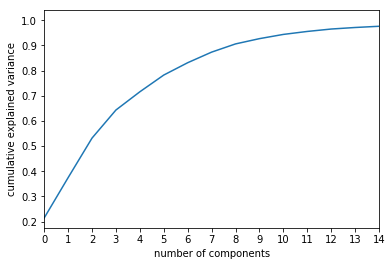

In [15]:
pca = PCA()
result_cbow = pca.fit_transform(X_cbow)

# result_skip = pca.fit_transform(X_skip)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xlim(right=10)
plt.xlim(left=0)
plt.xticks(np.arange(0, 15, step=1))
plt.ylabel('cumulative explained variance')
plt.show()

In [16]:
pca = PCA(n_components=8)
result_cbow = pca.fit_transform(X_cbow)
result_skip = pca.fit_transform(X_skip)

In [17]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

pca_df_cbow = pd.DataFrame()
pca_df_cbow['pca-one'] = result_cbow[:,0]
pca_df_cbow['pca-two'] = result_cbow[:,1]
pca_df_cbow['pca-three'] = result_cbow[:,2]

pca_df_skip = pd.DataFrame()
pca_df_skip['pca-one'] = result_skip[:,0]
pca_df_skip['pca-two'] = result_skip[:,1]
pca_df_skip['pca-three'] = result_skip[:,2]

Explained variation per principal component: [0.11958182 0.09747004 0.07846321 0.07472285 0.0624868  0.06082512
 0.04529219 0.04369476]


## model_cbow shown using PCA  

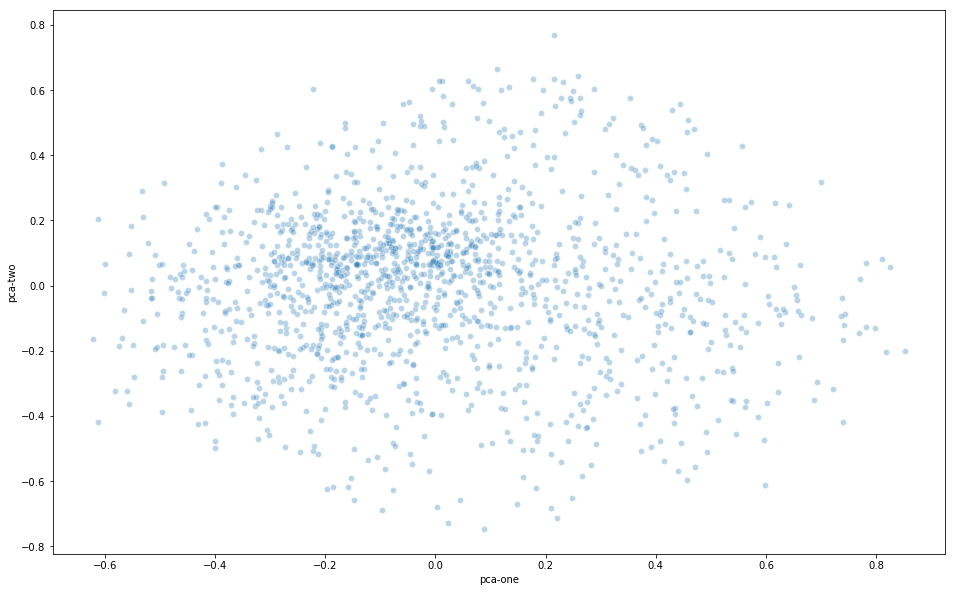

In [18]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=pca_df_cbow,
    legend="full",
    alpha=0.3
)

In [19]:
trace1 = go.Scatter3d(
    x=pca_df_cbow['pca-one'], 
    y=pca_df_cbow['pca-two'], 
    z=pca_df_cbow['pca-three'],
    mode='markers',
    marker=dict(
        size=5,
#         color=subset_bidask.values,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.8,
        colorbar={"thickness": 15, "len": 0.8, "x": 0.8, "y": 0.4, }
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

## model_skipgram shown using PCA  

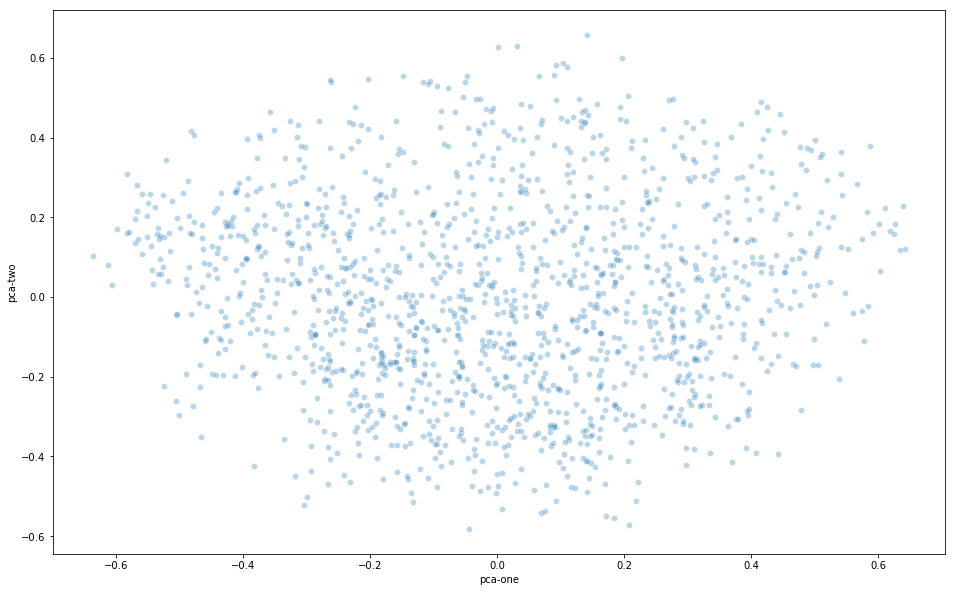

In [20]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=pca_df_skip,
    legend="full",
    alpha=0.3
)

In [21]:
trace1 = go.Scatter3d(
    x=pca_df_skip['pca-one'], 
    y=pca_df_skip['pca-two'], 
    z=pca_df_skip['pca-three'],
    mode='markers',
    marker=dict(
        size=5,
#         color=subset_bidask.values,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.8,
        colorbar={"thickness": 15, "len": 0.8, "x": 0.8, "y": 0.4, }
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')